The first step is getting the raw data that will allow us to do the actual analysis. This will include:
 - **Geographic data** of the areas in which we want to analyze diversity.
 - **Demographic data** for the same geographical areas

# Geographic data
Luckily the US Census Bureau has us covered, providing "shapefiles" for all sorts of things through something called [TIGER](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Census+Tracts) (rawwwwwr):

From the drop-down menu for Census Tract (2010) select California, then click the "Download state file" button. Wonderfully, the download doesn't begin. Checking the javascript console reveals that:

> ``index.php?year=2010&layergroup=Census+Tracts:1 Mixed Content: The page at 'https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Census+Tracts' was loaded over HTTPS, but requested an insecure resource 'http://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_06001_tract10.zip'. This request has been blocked; the content must be served over HTTPS.``

So just reload the page changing ``https:`` to ``http:`` and get yourself some geodata!

The file is named `tl_2010_06_tract10.zip`, `2010` referring to the census year, `06` is the state code for California. Shapefiles are proprietary (boo) and old, so we convert them to the cooler geoJSON format using a command-line tool called `ogr2ogr`.

In [ ]:
!ogr2ogr -f GeoJSON -t_srs crs:84 ca-tract.geojson ../geodata/ca-tract-shapefiles/tl_2010_06_tract10.shp

Now the file is good plain `json` with special fields that make it "GEO." So we load it with the `json` python module

In [1]:
import json

In [ ]:
with open('ca-tract.geojson', 'r') as f:
    geodata = json.load(f)

This file contains the entire state of California, but for now I just want to look at the "Bay Area" counties. The census uses something called FIPS codes to refer to those, which I got from wikipedia:
 - [Alameda County (1)](https://en.wikipedia.org/wiki/Alameda_county)
 - SF County (75)
 - Marin County (41)
 - Contra Costa County (13)
 
I'll use these codes to filter out the geodata for just those counties and save it to another, smaller geoJSON file.

In [2]:
county_codes = [1, 13, 41, 75]
county_codes_str = ['%3.3i' % c for c in county_codes]

In [ ]:
geodata_bayarea = dict(crs=geodata['crs'], type=geodata['type'])
geodata_bayarea['features'] = [f for f in geodata['features'] if f['properties']['COUNTYFP10'] in county_codes_str]
with open('bayarea-tract.geojson', 'w') as f:
    json.dump(geodata_bayarea, f)

In [3]:
with open('bayarea-tract.geojson', 'r') as f:
    geodata_bayarea = json.load(f)

# Demographic data

The US Census Bureau operates an API for finding census data at http://factfinder.census.gov/
I found the census data through the "[Download Center](http://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml)"

There are a couple of steps:
 - Select the radio button **I know the dataset or table(s) that I want to download**, then **Next**
 - Select **Decennial Census** from the dropdown menu
 - Select **2010 SF 100% Data**, then **Add to your selections**, then **Next**
 - Select **State ... Place ... County (or part) ... Census Tract (or part)**

The table named **Race and Hispanic or Latino Origin: 2010** contains counts for all races. Select that, download it and you're off!

In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
demdata = pd.read_csv('../censusdata/DEC_10_SF1_QTP3_with_ann.csv')

In [6]:
column_description = demdata.ix[0]
demdata = demdata.ix[1:].copy()

In [7]:
column_mapper = {'GEO.id': 'geoid',
     'HD01_S01': 'total',
     'HD01_S02': 'one_race',
     'HD01_S03': 'numWhite',
     'HD01_S04': 'numBlack',
     'HD01_S05': 'numAI',
     'HD01_S10': 'numAsian',
     'HD01_S23': 'num1Other',
     'HD01_S24': 'num2Other',
     'HD01_S30': 'numHisp'}
demdata = demdata[column_mapper.keys()]
demdata.rename(columns=column_mapper, inplace=True)

We need to do a little parsing of the geo id to get the county code and tract numbers. The `extract` method appears to do what we want, extracting substrings based on regular expression matches.

In [8]:
demdata['county'] = demdata.geoid.str.extract('US06(\d\d\d)')
demdata = demdata.ix[demdata.county.isin(county_codes_str)].copy()
demdata['tract'] = demdata.geoid.str.extract('US\d\d\d\d\d(\d\d\d\d)')
demdata.set_index('geoid', inplace=True)
demdata.head(4)

,numAsian,numHisp,num2Other,numWhite,one_race,total,num1Other,numAI,numBlack,county,tract
geoid,,,,,,,,,,,
1400000US06001400100,456,117,116,2161,2821,2937,49,4,142,001,4001
1400000US06001400200,147,151,115,1659,1859,1974,16,4,33,001,4002
1400000US06001400300,423,399,319,3468,4546,4865,115,17,518,001,4003
1400000US06001400400,278,332,230,2628,3473,3703,91,14,456,001,4004


In [9]:
demdata = demdata.astype(str)

A few of the entries contain a suffix (r39...). I don't know exactly what that means, but my hunch is that it's tagging data that was revised for some reason or another. In any case, it messes with the conversion from string to integer, so it's gotta go.

Again `Series.extract` is our string parsing friend.

Here, I convert everything to `int`, printing the changes to make sure nothing wonky happens.

In [10]:
for col in demdata:
    demdata_col = demdata[col]
    demdata_col_extract = demdata_col.str.extract('(\d+)')
    demdata[col] = demdata_col_extract.astype(int)

In [11]:
demdata_counts = demdata.filter(regex='^num')

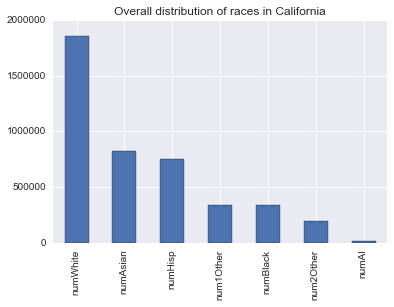

In [12]:
fig, ax = plt.subplots();
demdata_counts.sum().sort_values(ascending=False).plot.bar(ax=ax);
ax.set_title('Overall distribution of races in California');

# Compute diversity index
Now we need some way to turn all these census counts into some value that expresses diversity. I read about a method used by [Missouri state](http://diversity.missouristate.edu/DiversityIndex.htm) that seemed to make intuitive sense. It's the probability that two randomly chosen people in the census tract will be of different races and comes directly from some very basic laws of probability. Start with a formula for "Homogeneity," the probability of drawing two people of the same race. Since draws are independent, that probability is
$$P(\text{race1})*P(\text{race1})=P(\text{race1})^2$$

Then the probability of drawing two people of the same race is the sum of the squared probabilities for each of the races.

$$\text{Homogeneity}=P(\text{Asian})^2+P(\text{Black})^2+P(\text{Hispanic})^2+P(\text{White})^2+P(\text{Other})^2$$

$$\text{Diversity}=1-\text{Homogeneity}$$

In [13]:
def calculate_diversity(df):
    total = df.sum(1)
    col_names = df.columns
    p = pd.DataFrame(index=df.index)
    for col_name in col_names:
        p[col_name.replace('num', 'p')] = df[col_name]/total
    
    diversity = (1-(p**2).sum(1))*100
    return diversity

In [14]:
demdata['diversity'] = calculate_diversity(demdata_counts)

# Combining geographic and demographic data
Now we make ourselves a *choropleth*, which is the fancy cartographer's word for colory map. We'll use the fantastic python module [folium](https://github.com/python-visualization/folium), which makes beautiful d3 maps without me having to type a line of javascript.

In [15]:
import folium

In [16]:
def area_for_polygon(polygon):
    result = 0
    imax = len(polygon) - 1
    for i in range(0,imax):
        result += (polygon[i][0] * polygon[i+1][1]) - (polygon[i+1][0] * polygon[i][1])
    result += (polygon[imax][0] * polygon[0][1]) - (polygon[0][0] * polygon[imax][1])
    return result / 2.

def centroid_for_polygon(polygon):
    area = area_for_polygon(polygon)
    imax = len(polygon) - 1

    result_x = 0
    result_y = 0
    for i in range(0,imax):
        result_x += (polygon[i][0] + polygon[i+1][0]) * ((polygon[i][0] * polygon[i+1][1]) - (polygon[i+1][0] * polygon[i][1]))
        result_y += (polygon[i][1] + polygon[i+1][1]) * ((polygon[i][0] * polygon[i+1][1]) - (polygon[i+1][0] * polygon[i][1]))
    result_x += (polygon[imax][0] + polygon[0][0]) * ((polygon[imax][0] * polygon[0][1]) - (polygon[0][0] * polygon[imax][1]))
    result_y += (polygon[imax][1] + polygon[0][1]) * ((polygon[imax][0] * polygon[0][1]) - (polygon[0][0] * polygon[imax][1]))
    result_x /= (area * 6.0)
    result_y /= (area * 6.0)

    return result_x, result_y

In [17]:
centroids = []
geoids = []
for f in geodata_bayarea['features']:
    if f['geometry']['type']=='Polygon':
        lon, lat = centroid_for_polygon(f['geometry']['coordinates'][0])
        centroids.append([lat, lon])
        geoids.append(f['properties']['GEOID10'])

In [18]:
lat_centroids, lon_centroids = zip(*centroids)

In [19]:
centroid_df = pd.DataFrame({'geoid10':geoids, 'lat_centroid':lat_centroids, 'lon_centroid':lon_centroids})
centroid_df.set_index('geoid10', inplace=True)

In [20]:
demdata['geoid10'] = demdata.index.str.extract('US(\d\d\d\d\d\d\d\d\d\d\d)')
demdata.set_index('geoid10', inplace=True)
demdata = demdata.join(centroid_df)
demdata.reset_index(inplace=True)

In [21]:
label_map = {'numAsian': 'Asian', 'numBlack': 'Black', 'numHisp': 'Hispanic', 'numWhite': 'White'}

In [22]:
threshold_scale = demdata.diversity.quantile(np.arange(0., 1., 0.2)).values.tolist()

In [23]:
from IPython.display import HTML

def inline_map(m, width=650, height=500):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed

In [24]:
m = folium.Map(location=[37.864364, -122.211114], zoom_start=9,
               tiles='Stamen Toner',
               attr='Map tiles by Stamen Design (stamen.com)')

m.geo_json(geo_path=r'bayarea-tract.geojson', data=demdata[['geoid10', 'diversity']], 
           columns=['geoid10', 'diversity'],
           key_on='feature.properties.GEOID10',
           fill_color='YlGnBu',
           fill_opacity=0.9,
           threshold_scale=threshold_scale)

m.create_map(path='bayarea-diversity-choropleth.html')
inline_map(m)